# Subset NGEN HydroFabric on S3

**Authors:**  
   - Tony Castronova <acastronova@cuahsi.org>    
   - Irene Garousi-Nejad <igarousi@cuahsi.org>  
    
**Last Updated:** 04.21.2023   

**Description**:  

The purpose of this Jupyter Notebook is to demonstrate how to extract the National Hydrologic Geospatial (Hydrofabric) at a specific area of interest. Once the Hydrofabric has been extracted, it can be used to execute the [NOAA Next Generation (NextGen) Water Resource Modeling Framework](https://github.com/NOAA-OWP/ngen). The Hydrofabric data are publicly available in the AWS catalog. In this notebook, we use Version 1.2 of the NGen Hydrofabric which is the most recent version available on the Amazon S3 Bucket as of the time of developing this notebook (https://nextgen-hydrofabric.s3.amazonaws.com/index.html#v1.2/).

**Software Requirements**:  

The software and operating system versions used to develop this notebook are listed below. To avoid encountering issues related to version conflicts among Python packages, we recommend creating a new environment variable and installing the required packages specifically for this notebook.

Tested on: MacOS Ventura 13.2.1  

> boto3: 1.26.76  
  dask-core: 2023.4.0  
  fiona: 1.9.3  
  fsspec: 2023.4.0  
  geopandas: 0.12.2   
  ipyleaflet: 0.17.2  
  ipywidgets: 7.7.5   
  matplotlib: 3.7.1   
  netcdf4: 1.6.3   
  numpy: 1.24.2  
  pandas: 2.0.0  
  requests: 2.28.2  
  s3fs: 2023.4.0  
  scipy: 1.10.1  
  xarray: 2023.4.1
  
**Supplementary Code**

This notebook relies on the following external scripts:  
- `subset.py` - A script originally written by Nels Frazier to subset the NGen Hydrofabric

In [1]:
import datetime

from ipyleaflet import *
from ipywidgets import Layout

from requests import Request
import geopandas as gpd
import pandas

import subset

import os
import time

Create a map and load the HydroFabric VPU geometries. These geometries have been prepared ahead of time and are stored in a HydroShare [resource](https://www.hydroshare.org/resource/35e8c6023c154b6298fcda280beda849/). HydroShare provides [WMS](https://docs.geoserver.org/latest/en/user/services/wms/index.html) and [WFS](https://docs.geoserver.org/latest/en/user/services/wfs/index.html) capabilities that enable us to easily display them on an interactive map.

Create the map using the following code:

In [16]:
defaultLayout=Layout(width='960px', height='940px')

# map_center = (41.74614949822607, -111.76617850993877) # logan, UT
map_center = (40.59, -111.15) # provo , UT 

m = Map(
    basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik, layout=defaultLayout),
    center=map_center,
    zoom=11,
    scroll_wheel_zoom=True,
    tap=False
    )

# add USGS Gages
m.add_layer(
    WMSLayer(
        url='http://arcgis.cuahsi.org/arcgis/services/NHD/usgs_gages/MapServer/WmsServer',
        layers='0',
        transparent=True,
        format='image/png',
        min_zoom=8,
        max_zoom=18,
        )
)

# add the CONUS VPU boundaries
m.add_layer(
    WMSLayer(
        url='https://geoserver.hydroshare.org/geoserver/HS-35e8c6023c154b6298fcda280beda849/wms?',
        layers='vpu_boundaries',
        format='image/png',
        transparent=True,
        opacity=0.5,
        min_zoom=4,
        max_zoom=8
    )
)

# add the watershed VPU boundaries for each region.
# for vpu in ['01', '02','03N','03S','03W', '04','05','06','07','08','09','10L','10U','11','12','13','14','15','16','17','18']:
for vpu in ['16']:
    m.add_layer(
        WMSLayer(
            url='https://geoserver.hydroshare.org/geoserver/HS-35e8c6023c154b6298fcda280beda849/wms?',
            layers=f'{vpu}_boundaries',
            format='image/png',
            transparent=True,
            opacity=0.5,
            min_zoom=8,
            max_zoom=18
        )
    )


Add an event handler that will enable us to highlight and store geometries that have been clicked on the map. When a geometry is clicked on the map, we'll call the `WFS` endpoint to retrieve the boundary of the shape. We can draw this boundary on the map and store information about the selected area for later use.

In [17]:
selected_df = None

def handle_map_interaction(**kwargs):
    global selected_df
    
    if kwargs.get('type') == 'click':
        coords = kwargs['coordinates'] 
        url = f'https://geoserver.hydroshare.org/geoserver/HS-35e8c6023c154b6298fcda280beda849/wfs?' \
               'service=wfs&version=2.0.0&' \
              f'request=getFeature&' \
               'srsName=EPSG:4269&' \
              f'bbox={coords[1]},{coords[0]},{coords[1]},{coords[0]},EPSG:4269&' \
              f'typeName=vpu_boundaries&' \
               'outputFormat=json&' \
               'PropertyName=VPU'
        q = Request('GET', url).prepare().url
        df = gpd.read_file(q, format='json')
        
        # exit if a VPU is not found, i.e. a user doesn't click on the layer
        if len(df) == 0: return
        
        VPU = df.VPU.values[0]
        url = f'https://geoserver.hydroshare.org/geoserver/HS-35e8c6023c154b6298fcda280beda849/wfs?' \
               'service=wfs&version=2.0.0&' \
              f'request=getFeature&' \
               'srsName=EPSG:4269&' \
              f'bbox={coords[1]},{coords[0]},{coords[1]},{coords[0]},EPSG:4269&' \
              f'typeName={VPU}_boundaries&' \
               'outputFormat=json&'
        q = Request('GET', url).prepare().url
        df = gpd.read_file(q, format='json')

        # exit if a VPU is not found, i.e. a user doesn't click on the layer
        if len(df) == 0: return
    
        # save vpu region, convert crs, and save selection for later
        df['VPU'] = VPU 
        df = df.to_crs('EPSG:4269')
        selected_df = df
        
        if type(m.layers[-1]) == WKTLayer:
            m.remove_layer(m.layers[-1])
            
        # display the watershed boundary on the map
        m.add_layer(WKTLayer(wkt_string=df.iloc[0].geometry.wkt))
        
m.on_interaction(handle_map_interaction)

Display the map

In [18]:
m

Map(center=[40.59, -111.15], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

Pass the `ids` of the geometries selected in the map to the hydrofabric subsetting script.

In [19]:
selected_df.id

0    cat-680628
Name: id, dtype: object

In [20]:

ids = list(selected_df.id.values)
vpus = list(selected_df.VPU.values)

output_files = []
for i in range(0, len(ids)):    
    print(50*'-'+f'\nProcessing VPU {vpus[i]}, {ids[i]} ')
    st = time.time()
    # build the hydrofabric_url
    hydrofabric_url = f's3://nextgen-hydrofabric/v1.2/nextgen_{vpus[i]}.gpkg'
    subset.subset_upstream(hydrofabric_url, ids[i])
    
    # move these files into a subdir to keep things orderly
    counter = 1
    outpath = ids[i]
    while os.path.exists(outpath):
        outpath = ids[i] + " (" + str(counter) + ")"
        counter += 1
    os.mkdir(outpath)
    for f in [f'{ids[i]}_upstream_subset.gpkg',
              'catchments.geojson',
              'crosswalk.json',
              'flowpath_edge_list.json',
              'flowpaths.geojson',
              'nexus.geojson']:
        os.rename(f, f'{outpath}/{f}')
        
    # output_files.append(f'{ids[i]}_upstream_subset.gpkg')
    print(f'Output files located at: {outpath}')
    print(f'Completed in {time.time() - st} seconds\n'+50*'-')    

--------------------------------------------------
Processing VPU 16, cat-680628 
flowpaths
divides
nexus
flowpath_attributes
flowpath_edge_list
crosswalk
cfe_noahowp_attributes
forcing_metadata
Output files located at: cat-680628
Completed in 96.45504355430603 seconds
--------------------------------------------------


## Preview the Output Geopackage

In [21]:
import geopandas

In [31]:
# load the geopackage
# ['flowpaths', 'divides', 'nexus', 'flowpath_attributes', 'flowpath_edge_list', 'crosswalk', 'cfe_noahowp_attributes', 'forcing_metadata']

results = geopandas.read_file(f'{ids[0]}/{ids[0]}_upstream_subset.gpkg', layer='divides')

In [32]:
# preview the dataframe contents
results.head()

,id,areasqkm,type,toid,geometry
0,cat-680625,3.933452,network,nex-680626,"MULTIPOLYGON (((-1250325.000 2059605.000, -125..."
1,cat-681077,7.774320,network,nex-680625,"MULTIPOLYGON (((-1247415.004 2060234.996, -124..."
2,cat-680628,8.363692,network,nex-680629,"MULTIPOLYGON (((-1250834.998 2050904.997, -125..."
3,cat-680624,7.418699,network,nex-680625,"MULTIPOLYGON (((-1247804.996 2061195.005, -124..."
4,cat-681076,10.130844,network,nex-680629,"MULTIPOLYGON (((-1251434.998 2056484.997, -125..."


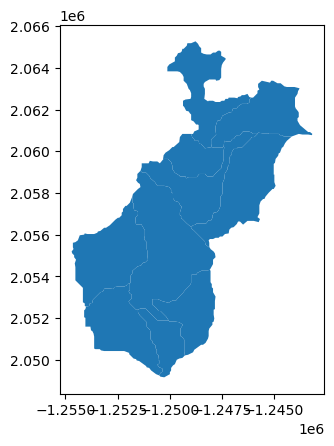

In [33]:
# preview map geometries
results.iloc[:].plot();